In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from siphon.catalog import TDSCatalog
import seaborn as sns
sns.set(style='white')
import numpy as np

from random import sample

import xarray as xr
from dask.distributed import Client

%config InlineBackend.figure_formats = ['png']
%matplotlib inline 

In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:33641 Dashboard: /user/acannistra/proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 25.77 GB


# [AquaMaps](http://www.aquamaps.org) vs GlobTherm Thermal Tolerances?

*Tony Cannistra, January 2020*

It would be nice to see how much thermal tolerances are actually encountered across observed species' ranges. We'll use the range maps from [AquaMaps.org](http://www.aquamaps.org), thermal tolerances from the [GlobalTherm](https://datadryad.org/stash/dataset/doi:10.5061/dryad.1cv08) dataset, and SST from OISST? 

## Thermal Tolerance Data

In [5]:
globtherm = pd.read_csv("../../data/globtherm/GlobalTherm_upload_02_11_17.csv", engine='python')

In [6]:
globtherm.head()

,Genus,Species,N,Tmax,max_metric,error,error measure,Multiple measures,max_interval_after_LT0,Tmax_2,...,lat_min,long_min,elevation_min,REF_min,location_min,Phylum,Class,Order,Family,Quality of UTNZ
0,Prochilodus,scrofa,10.0,35.7,ctmax,NaN,NaN,N,NaN,NaN,...,-22.0,-43.50,0.0,Barrionuevo_&_Fernandes_1995,2.0,Chordata,Actinopteri,Characiformes,Prochilodontidae,NaN
1,Lepomis,gibbosus,24.0,35.1,ctmax,NaN,NaN,Y,NaN,NaN,...,46.2,-119.00,NaN,Becker_et_al_1977,1.0,Chordata,Actinopteri,Perciformes,Centrarchidae,NaN
2,Cyprinodon,variegatus,100.0,44.2,ctmax,0.29,SD,Y,NaN,NaN,...,26.0,-97.15,0.0,Bennett_&_Beitinger_1997,1.0,Chordata,Actinopteri,Cyprinodontiformes,Cyprinodontidae,NaN
3,Oncorhynchus,keta,NaN,23.2,LT50,NaN,NaN,N,NaN,NaN,...,52.0,-128.90,0.0,Brett&Alderdice1958_in_Brett_1970,1.0,Chordata,Actinopteri,Salmoniformes,Salmonidae,NaN
4,Oncorhynchus,nerka,NaN,21.5,LT50,NaN,NaN,N,NaN,NaN,...,52.0,-128.90,0.0,Brett&Alderdice1958_in_Brett_1970,1.0,Chordata,Actinopteri,Salmoniformes,Salmonidae,NaN


### Examine the dataset a little bit

Text(0.5, 1.0, '$CT_{max}$ Metric Types, Whole Dataset')

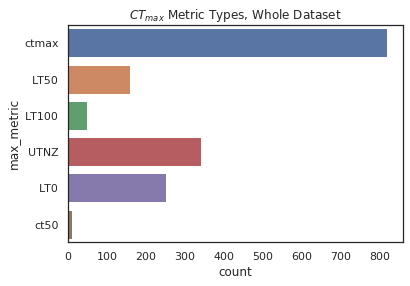

In [7]:
sns.countplot(data=globtherm, y='max_metric')
plt.title("$CT_{max}$ Metric Types, Whole Dataset")

### Max_Metric Types by Class

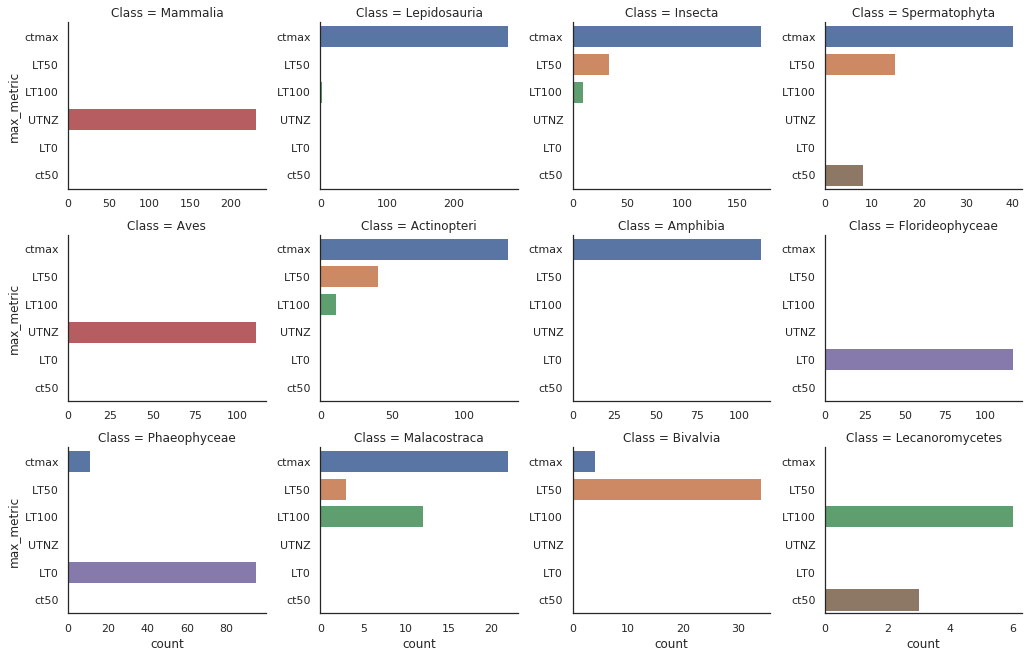

In [126]:
sns.catplot(col = 'Class', y = 'max_metric', 
            kind='count', col_wrap=4, col_order = globtherm.Class.value_counts().index[:12],
            sharex=False, sharey=False, 
            data = globtherm,height=3, aspect=1.2)

### Max_Metric Types of Fishes (*Actinopterygii*) by Order
Listed as out-of-date name "*Actinopteri*" in GlobTherm.


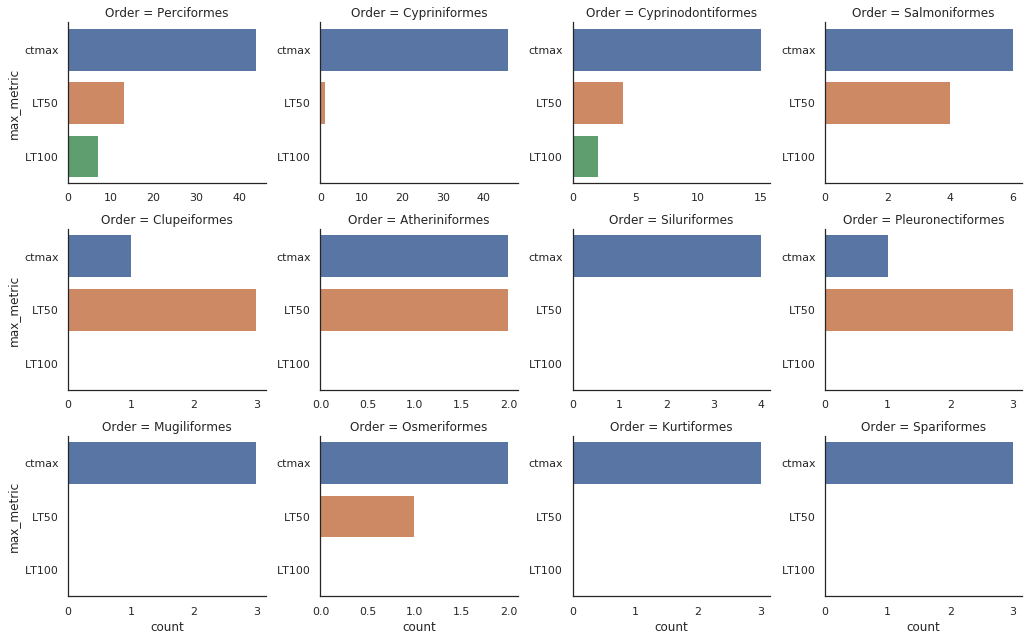

In [127]:
fishes = globtherm.query("Class == 'Actinopteri'")
g = sns.catplot(col="Order", y='max_metric',
               kind = 'count', col_wrap=4,
               sharex = False, sharey=False,
               col_order = fishes.Order.value_counts().index[:12],
               data = fishes, height=3, aspect=1.2)


plt.tight_layout()

### Number of Species in each Order

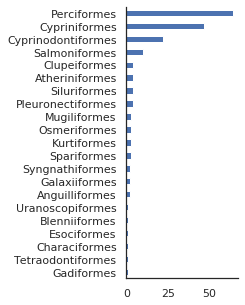

In [242]:
fig = plt.figure(figsize=(2, 5))
fishes.Order.value_counts(ascending=True).plot(kind='barh')
sns.despine()

## GlobalTherm Overlap with AquaMaps

In [8]:
AQUAMAPS_THREDDS = "https://thredds.d4science.org/thredds/catalog/public/netcdf/AquamapsNative/catalog.xml"
AQUAMAPS_FILE_TEMPLATE = "aquamaps_native_{}.nc"
aqmapsCatalog = TDSCatalog(AQUAMAPS_THREDDS)
datasets = aqmapsCatalog.datasets

In [9]:
genus_species_tuples = [tuple(d.split(".")[0].split('_')[2:]) for d in datasets]
tuple_lengths = np.array([len(i) for i in genus_species_tuples])
# deal with species w subspecies + other wierd cases
# genus_species_tuples = np.array([len(i) for i in genus_species_tuples])

genus_species_tuples = np.array([(i[0], "_".join(i[1:])) if len(i) == 3 else i for i in genus_species_tuples])
genus_species_tuples = genus_species_tuples[~(tuple_lengths < 2)]
genus_species_tuples

array([('abalistes', 'stellaris'), ('abalistes', 'stellatus'),
       ('abietinella', 'operculata'), ..., ('zoramia', 'viridiventer'),
       ('zosterisessor', 'ophiocephalus'), ('zu', 'elongatus')],
      dtype=object)

In [10]:
genus,species = list(zip(*genus_species_tuples))


In [11]:
aq_species = pd.DataFrame(data=np.array([genus, species]).T, columns=['genus', 'species'])

In [12]:
globtherm_overlap = globtherm.merge(aq_species,
                                    left_on = [globtherm.Genus.str.lower(), globtherm.Species.str.lower()],
                                    right_on = [aq_species.genus, aq_species.species])

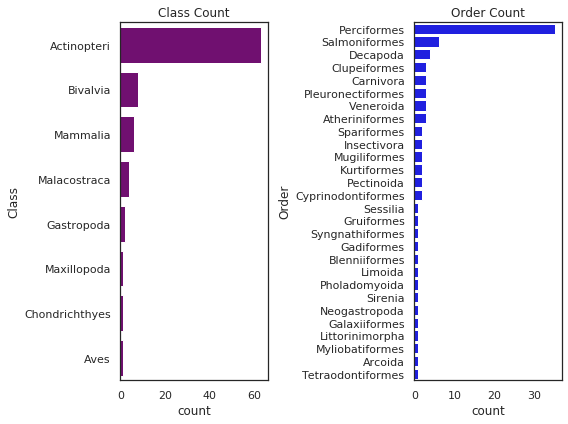

In [13]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(8,6))

sns.countplot(y='Class', data=globtherm_overlap, order = globtherm_overlap.Class.value_counts().index, color='purple', ax=axes[0])
axes[0].set_title("Class Count")
sns.countplot(y='Order', data=globtherm_overlap, order = globtherm_overlap.Order.value_counts().index, color='blue', ax=axes[1])
axes[1].set_title("Order Count")

plt.tight_layout()

## Get a few random *Actinopterygii* and plot their ranges

In [14]:
overlap_fishes = globtherm_overlap[globtherm_overlap.Class == "Actinopteri"]

In [15]:
overlap_filenames = [AQUAMAPS_FILE_TEMPLATE.format("_".join(i)) 
                     for i in list(zip(overlap_fishes.Genus.str.lower(), overlap_fishes.Species.str.lower()))]

In [16]:
random_fishes = overlap_filenames
random_fishes_urls = [datasets.get(i).access_urls['OPENDAP'] for i in random_fishes]
multi = xr.open_mfdataset(random_fishes_urls, combine='nested', concat_dim='species', parallel = True)

In [17]:
multi = multi.assign_coords({'species': ["_".join(rf.split("_")[2:]) for rf in random_fishes]})

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/plot/facetgrid.py:365: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


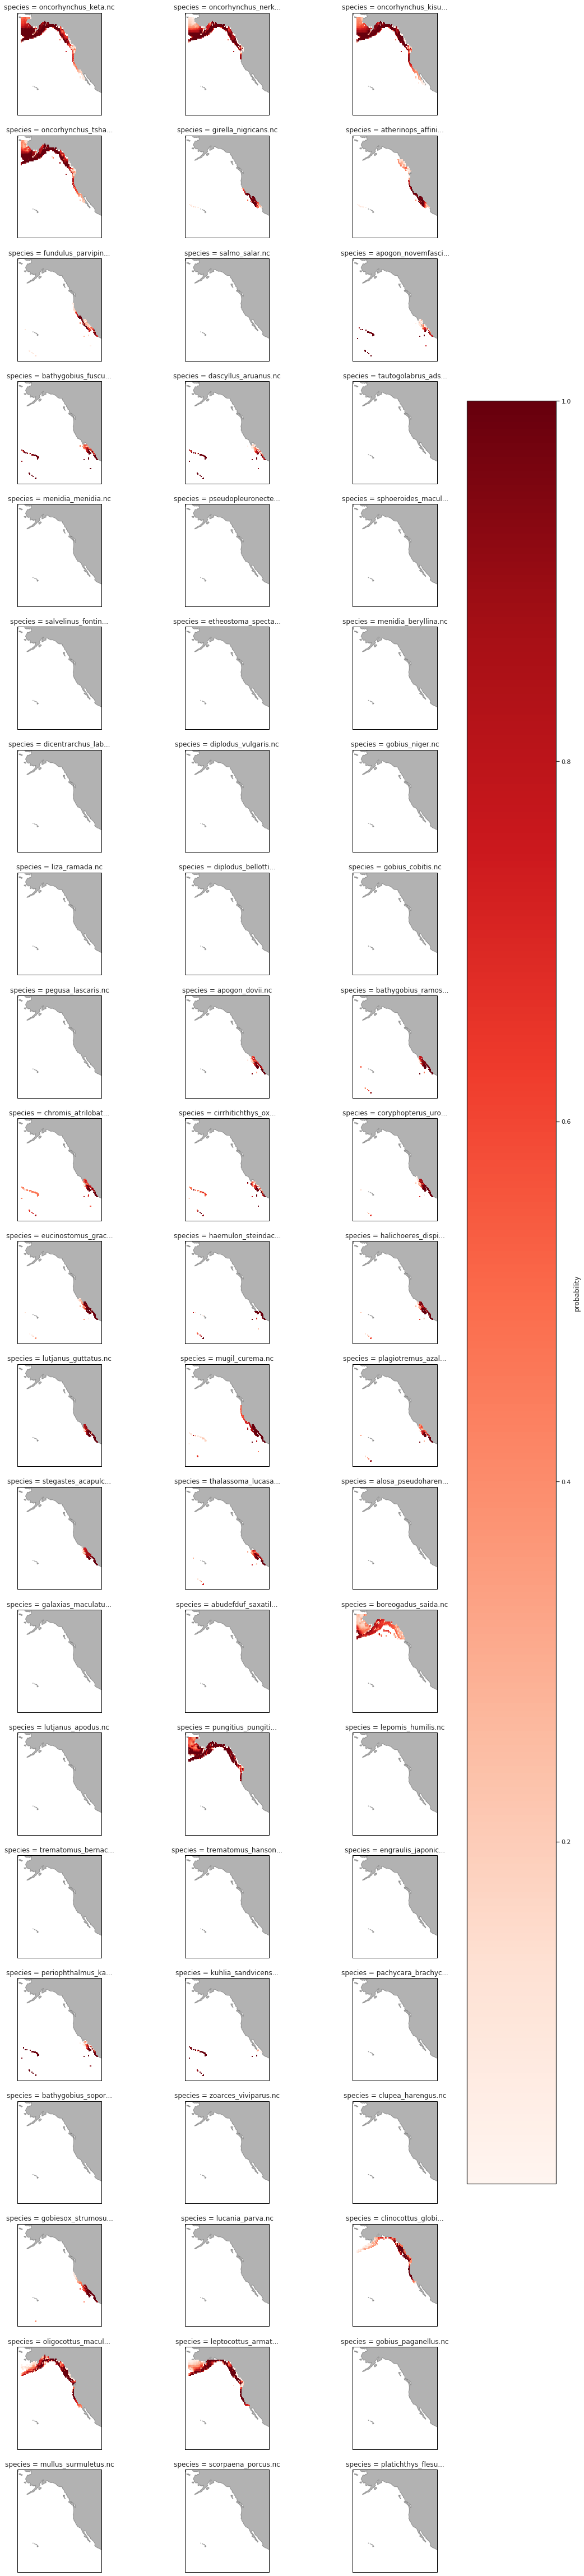

In [19]:
PNW = multi.sel(latitude = slice(1.52, 63.4), longitude=slice(-170, -103))
p = PNW.probability.plot(transform=ccrs.PlateCarree(),
                           x = 'longitude', y = 'latitude', col='species',
                           aspect=1.5, size=4, cmap='Reds',
                           col_wrap = 3, subplot_kws={'projection': ccrs.Mercator().GOOGLE})

for ax in p.axes.flat:
    ax.add_feature(cf.LAND, color='black', alpha=0.3)
#     ax.set_extent([-170, -103, 1.52, 63.4], crs=ccrs.PlateCarree())


## Compare Ranges with SST via OISST dataset. 